#Fiscal rules in the UK

What would be the impact of various fiscal rules on the long-run fiscal position in the UK? How would they affect the rate of fiscal consolidation over this Parliament?

In [1]:
import numpy as np
import pandas as pd
import pyscraper
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

from plotly.widgets import GraphWidget
from plotly.graph_objs import *
import plotly.plotly as py
import plotly.tools as tls

from IPython.display import display
from IPython.html import widgets


%matplotlib inline

:0: FutureWarning:

IPython widgets are experimental and may change in the future.



<IPython.core.display.Javascript object>

#Import data

Fiscal policy so work in fiscal years.

Need LR forecasts so:

OBR Databank (2014-2018):
 - NGDP
 - RGDP
 - Primary balance
 - PSNB
 - PSND
 
OBR FSR (2019-2063)
 - NGDP
 - RGDP
 - Primary balance
 - PSNB
 - PSND
 
##OBR Databank

In [2]:
obr_databank_pc = pd.read_excel('http://budgetresponsibility.org.uk/pubs/PSF_aggregates_databank_October-2014.xls', 'Aggregates (per cent of GDP)',
                              header=0,
                              skiprows=3,
                              skip_footer=8,
                              index_col=0,
                              parse_cols="B:H,J:N,P:Q,S:T,V:X,Z:AA",
                              na_values=["-"],
                              parse_dates=True)
obr_databank_pc.index = pd.Index(pd.date_range(start=pd.datetime(1948, 3, 31), end=pd.datetime(2018, 3, 31), freq='A-MAR'))

obr_databank_gdp_deflator = pd.read_excel('http://budgetresponsibility.org.uk/pubs/PSF_aggregates_databank_October-2014.xls', 'Aggregates (£bn)',
                              header=0,
                              skiprows=3,
                              skip_footer=6,
                              index_col=0,
                              parse_cols="B,AB",
                              na_values=["-"],
                              parse_dates=True)
obr_databank_pc.index = pd.Index(pd.date_range(start=pd.datetime(1948, 3, 31), end=pd.datetime(2018, 3, 31), freq='A-MAR'))

obr_databank_pc['GDP Deflator (2013-14=100)'] = obr_databank_gdp_deflator.iloc[5:].values

In [3]:
obr_databank_pc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71 entries, 1948-03-31 00:00:00 to 2018-03-31 00:00:00
Freq: A-MAR
Data columns (total 21 columns):
Public sector current receipts                71 non-null float64
Total managed expenditure                     71 non-null float64
Public sector current expenditure             71 non-null float64
Public sector net investment                  71 non-null float64
Depreciation                                  71 non-null float64
Public sector gross investment                71 non-null float64
Public sector net borrowing                   71 non-null float64
Cyclically-adjusted net borrowing             45 non-null float64
Current budget deficit                        71 non-null float64
Primary balance                               71 non-null float64
Cyclically-adjusted primary balance           45 non-null float64
Cyclically-adjusted current budget deficit    45 non-null float64
Public sector net debt2                       27 non-nu

##OBR Fiscal Sustainability Report

In [4]:
obr_fsr_pc = pd.read_excel('http://budgetresponsibility.org.uk/pubs/FSR_2014_Supplementary_Tables.xls', '1.1',
                              header=0,
                              skiprows=3,
                              #skip_footer=8,
                              index_col=0,
                              parse_cols="B:BA",
                              na_values=["-"],
                              parse_dates=True).dropna().T
obr_fsr_pc.index = pd.Index(pd.date_range(start=pd.datetime(2013, 3, 31), end=pd.datetime(2063, 3, 31), freq='A-MAR'))

obr_fsr_pc_hp = pd.read_excel('http://budgetresponsibility.org.uk/pubs/FSR_2014_Supplementary_Tables.xls', '1.8',
                              header=0,
                              skiprows=3,
                              #skip_footer=8,
                              index_col=0,
                              parse_cols="B:BA",
                              na_values=["-"],
                              parse_dates=True).dropna().T
obr_fsr_pc_hp.index = pd.Index(pd.date_range(start=pd.datetime(2013, 3, 31), end=pd.datetime(2063, 3, 31), freq='A-MAR'))

In [5]:
obr_fsr_pc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2013-03-31 00:00:00 to 2063-03-31 00:00:00
Freq: A-MAR
Data columns (total 25 columns):
Real GDP growth                   51 non-null float64
Nominal GDP growth                51 non-null float64
Gilt rate                         51 non-null float64
Health                            51 non-null float64
Long-term care                    51 non-null float64
Education                         51 non-null float64
Pensions                          51 non-null float64
Pensioner benefits                51 non-null float64
Public service pensions           51 non-null float64
Other social benefits             51 non-null float64
Other spending                    51 non-null float64
Total non-interest spending       51 non-null float64
Income tax                        51 non-null float64
NICs                              51 non-null float64
Corporation tax                   51 non-null float64
VAT                               51 

##Bank of England database

Bank rate series. This series does not have forecasts 

In [7]:
boe_bank_rate = pyscraper.scrape.from_BoE(['IUDBEDR'], yearsback=50)

CSV retrieved from http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes&Datefrom=11/Mar/1965&Dateto=now&SeriesCodes=IUDBEDR&UsingCodes=Y&CSVF=TN&VPD=y


##Mung into a single dataset

Column names vary because of capitalisation and footnotes. Discard all numeric column names and convert to lower case.

In [8]:
for df in [obr_databank_pc, obr_fsr_pc, obr_fsr_pc_hp]:
    df.columns = [''.join(i.lower() for i in j.strip() if not i.isdigit()) for j in df.columns]

In [9]:
lr_pusf = obr_databank_pc.combine_first(obr_fsr_pc)[['gilt rate', 'public sector net debt', 'primary balance', 'total managed expenditure', 'public sector net borrowing', 'public sector current receipts']]
lr_pusf_hp = obr_databank_pc.combine_first(obr_fsr_pc_hp)[['gilt rate', 'public sector net debt', 'primary balance', 'total managed expenditure', 'public sector net borrowing', 'public sector current receipts']]

Construct NGDP and RGDP series from FSR's GDP growth rates.

In [10]:
fsr_lr_gdp_deflator = 0.022

gdp_seed = pd.DataFrame(obr_databank_pc['nominal gdp (£ billion)'].combine_first(obr_fsr_pc['nominal gdp growth']))
gdp_seed['gdp deflator (2013-14=100)'] = obr_databank_pc['gdp deflator (-=)']

for i, v in iter(gdp_seed['nominal gdp (£ billion)'].items()):
    if i > pd.datetime(2018, 3, 31):
        gdp_seed['nominal gdp (£ billion)'][i] = gdp_seed['nominal gdp (£ billion)'][i - pd.DateOffset(years=1)] * (1 + v/100)
        gdp_seed['gdp deflator (2013-14=100)'][i] = gdp_seed['gdp deflator (2013-14=100)'][i - pd.DateOffset(years=1)] * (1 + fsr_lr_gdp_deflator)

gdp_seed['real gdp (2013-14 pounds)'] = gdp_seed['nominal gdp (£ billion)'].div(gdp_seed['gdp deflator (2013-14=100)']).mul(100.)
lr_df = lr_pusf.join(gdp_seed).join(boe_bank_rate.resample('A-MAR', how=min))
lr_df_hp = lr_pusf_hp.join(gdp_seed).join(boe_bank_rate.resample('A-MAR', how=min))

In [11]:
lr_df.rename(columns={'gilt rate': 'gilt', 
              'public sector net debt': 'psnd', 
              'primary balance': 'primsurp', 
              'total managed expenditure': 'tme', 
              'public sector net borrowing': 'psnb', 
              'public sector current receipts': 'pscr', 
              'nominal gdp (£ billion)': 'ngdp', 
              'gdp deflator (2013-14=100)': 'gdp_defl', 
              'real gdp (2013-14 pounds)': 'rgdp', 
              'IUDBEDR': 'bank_rate'}, inplace=True)
lr_df[['gilt', 'psnd', 'primsurp', 'tme', 'psnb', 'pscr']] = lr_df[['gilt', 'psnd', 'primsurp', 'tme', 'psnb', 'pscr']].div(100)

In [12]:
lr_df

gilt  psnd  primsurp    tme   psnb   pscr          ngdp  \
1948-03-31   NaN   NaN     0.073  0.377 -0.041  0.419     12.000000   
1949-03-31   NaN   NaN     0.075  0.377 -0.046  0.423     12.700000   
1950-03-31   NaN   NaN     0.062  0.384 -0.035  0.419     13.300000   
1951-03-31   NaN   NaN     0.033  0.402 -0.005  0.407     14.800000   
1952-03-31   NaN   NaN     0.019  0.410  0.013  0.397     16.000000   
1953-03-31   NaN   NaN     0.004  0.402  0.024  0.377     17.100000   
1954-03-31   NaN   NaN     0.010  0.385  0.014  0.371     18.100000   
1955-03-31   NaN   NaN     0.027  0.363 -0.002  0.365     19.700000   
1956-03-31   NaN   NaN     0.018  0.365  0.004  0.362     21.300000   
1957-03-31   NaN   NaN     0.022  0.358  0.000  0.358     22.600000   
1958-03-31   NaN   NaN     0.023  0.366  0.003  0.363     23.400000   
1959-03-31   NaN   NaN     0.015  0.367  0.023  0.344     24.800000   
1960-03-31   NaN   NaN     0.014  0.366  0.025  0.341     26.600000   
1961-03-31   NaN   NaN     0.018  0.382  0.022  0.360     27.900000   
1962-03-31   NaN   NaN     0.019  0.380  0.018  0.361     29.200000   
1963-03-31   NaN   NaN     0.009  0.382  0.027  0.355     31.700000   
1964-03-31   NaN   NaN     0.016  0.380  0.019  0.361     34.500000   
1965-03-31   NaN   NaN     0.018  0.395  0.015  0.380     37.000000   
1966-03-31   NaN   NaN     0.010  0.412  0.024  0.387     39.300000   
1967-03-31   NaN   NaN    -0.002  0.442  0.039  0.403     41.800000   
1968-03-31   NaN   NaN     0.030  0.426  0.006  0.420     45.800000   
1969-03-31   NaN   NaN     0.053  0.414 -0.018  0.431     49.500000   
1970-03-31   NaN   NaN     0.038  0.408 -0.006  0.414     56.000000   
1971-03-31   NaN   NaN     0.020  0.408  0.010  0.398     62.500000   
1972-03-31   NaN   NaN     0.002  0.401  0.027  0.374     71.200000   
1973-03-31   NaN   NaN    -0.011  0.421  0.043  0.378     79.400000   
1974-03-31   NaN   NaN    -0.024  0.470  0.060  0.410     93.300000   
1975-03-31   NaN   NaN    -0.032  0.489  0.067  0.423    114.600000   
1976-03-31   NaN   NaN    -0.014  0.478  0.052  0.426    134.100000   
1977-03-31   NaN   NaN    -0.003  0.448  0.041  0.407    156.700000   
...          ...   ...       ...    ...    ...    ...           ...   
2034-03-31  0.05  0.53     0.004  0.397  0.013  0.384   4217.476517   
2035-03-31  0.05  0.53     0.005  0.397  0.013  0.384   4415.697914   
2036-03-31  0.05  0.53     0.004  0.398  0.013  0.385   4623.235716   
2037-03-31  0.05  0.54     0.002  0.400  0.015  0.385   4835.904558   
2038-03-31  0.05  0.54     0.001  0.401  0.016  0.385   5058.356168   
2039-03-31  0.05  0.54    -0.001  0.403  0.018  0.386   5291.040552   
2040-03-31  0.05  0.55    -0.002  0.405  0.019  0.386   5534.428417   
2041-03-31  0.05  0.55    -0.003  0.406  0.020  0.386   5789.012124   
2042-03-31  0.05  0.56    -0.004  0.407  0.021  0.387   6055.306682   
2043-03-31  0.05  0.57    -0.005  0.409  0.022  0.387   6333.850790   
2044-03-31  0.05  0.57    -0.005  0.410  0.023  0.387   6625.207926   
2045-03-31  0.05  0.58    -0.006  0.411  0.024  0.387   6929.967490   
2046-03-31  0.05  0.59    -0.009  0.414  0.027  0.387   7255.675963   
2047-03-31  0.05  0.60    -0.010  0.415  0.028  0.387   7596.692733   
2048-03-31  0.05  0.61    -0.009  0.415  0.028  0.387   7946.140598   
2049-03-31  0.05  0.62    -0.010  0.416  0.029  0.387   8311.663066   
2050-03-31  0.05  0.63    -0.011  0.418  0.031  0.387   8693.999567   
2051-03-31  0.05  0.64    -0.012  0.419  0.032  0.387   9093.923547   
2052-03-31  0.05  0.66    -0.013  0.421  0.034  0.387   9512.244030   
2053-03-31  0.05  0.67    -0.013  0.423  0.035  0.387   9949.807256   
2054-03-31  0.05  0.68    -0.014  0.424  0.037  0.387  10397.548582   
2055-03-31  0.05  0.70    -0.015  0.426  0.038  0.388  10875.835817   
2056-03-31  0.05  0.72    -0.016  0.427  0.040  0.388  11376.124265   
2057-03-31  0.05  0.73    -0.016  0.429  0.041  0.388  11899.425981   
2058-03-31  0.05  0.75    -0.017  0.

###Implied effective gilt rate on net debt

Calculating a path for net debt requires knowing the interest rate on all assets, along with any incidental costs and incomes. To proxy that, I use the effective gilt rate implied by the OBR forecasts. From a formula for the accumulation of debt is is possible to back out the effective, nominal gilt rate implied by the EFO and FSR.

$$i_t = \frac{(d_t - d_{t-1} + p_t)(1+\gamma_t)}{d_{t-1}} + \gamma_t$$

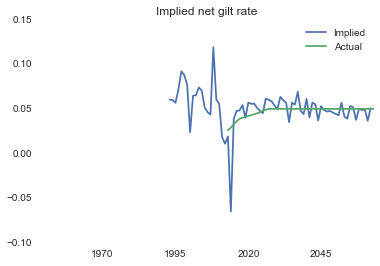

In [13]:
iegr = (lr_df['psnd'].diff() + lr_df['primsurp']).div(lr_df['psnd'].shift(-1)).mul(1 + lr_df['ngdp'].pct_change()) + lr_df['ngdp'].pct_change()
giltax = iegr.plot(title='Implied net gilt rate')
lr_df.gilt.plot(ax=giltax)
giltax.legend(['Implied', 'Actual'])

In [14]:
lr_df['eff_gilt'] = iegr

# Implications of a Swiss-style fiscal rule in the UK

How would the UK fiscal balance look if we implemented a Swiss-style fiscal rule?

The allowable expenditure is $revenue_t \times k_t$ where $k_t = \frac{Y^*_t}{Y_t}$.

Estimating potential output, $Y^*_t$ uses a modified HP filter. The Swiss use a re-weighted filter to deal with endpoint problems. Here it makes more sense to use the forecasts since we're looking at a long-run outcome.

When outcomes vary from the allowed expenditure then the money goes into a credit account. If the account exceeds 6 per cent of GDP then it is required to be reduced within 3 years. If the rule is suspended in exceptional circumstances then the excesses are credited to an amortisation account that has to be repaid within six years.

##Calculating allowed expenditure

In [15]:
class SwissRule():
    """
    Calculate a Swiss debt rule for a given GDP/expenditure series. Generate various, useful supporting stats.
    
    Takes:
        ngdp: nominal GDP
        rgdp: real GDP
        revenue: Government revenue as a percentage of GDP (ie. 38, not 0.38)
        expenditure: Government expenditure as a percentage of GDP
    
    All data should be annual by fiscal year
    """
    
    def __init__(self, ngdp, rgdp, revenue, expenditure):
        self.rgdp = rgdp
        self.ngdp = ngdp
        self.revenue_pc = revenue
        self.expenditure_pc = expenditure
        self.revenue = self.revenue_pc.div(100) * self.ngdp  # in cash terms
        self.expenditure = self.expenditure_pc.div(100) * self.ngdp  # in cash terms
        self.gdp_cycle, self.gdp_trend, self.hp_outputgap = self._hp_output_gap()
        
    def _hp_output_gap(self):
        """
        Calculate the HP-filtered output gap and return the cycle, trend, and output gap from FY data.
        """
        gdp_cycle, gdp_trend = hpfilter(self.rgdp.dropna(), lamb=6.25)
        hp_outputgap = gdp_cycle.mul(100.).div(self.rgdp)

        return gdp_cycle, gdp_trend, hp_outputgap

    def allowed_expenditure(self, pc=True):
        """Allowed expenditure under the Swiss rule"""
        allowed_cash = self.gdp_trend.div(self.rgdp).mul(self.revenue)
        if pc:
            return allowed_cash.div(self.ngdp).mul(100)
        else:
            return allowed_cash

    def credit_account(self, pc=True, cum=True, from_date=pd.datetime(2000, 1, 1)):
        """
        Amortisation account value
        
        Takes:
            pc: Return percentage of GDP (bool)
            cum: Return cumulative value since from_date (bool)
            from_date: date to calculate from (pandas datetime)
        """
        cash_surplus = self.allowed_expenditure(pc=False).sub(self.expenditure)
        if cum:
            cash_surplus = cash_surplus[from_date:].cumsum()
        if pc:
            return cash_surplus[from_date:].div(self.ngdp).mul(100)
        else:
            return cash_surplus[from_date:]

In [16]:
swiss = SwissRule(lr_df['ngdp'], lr_df['rgdp'], lr_df['pscr'], lr_df['tme'])

##Charting the outputs

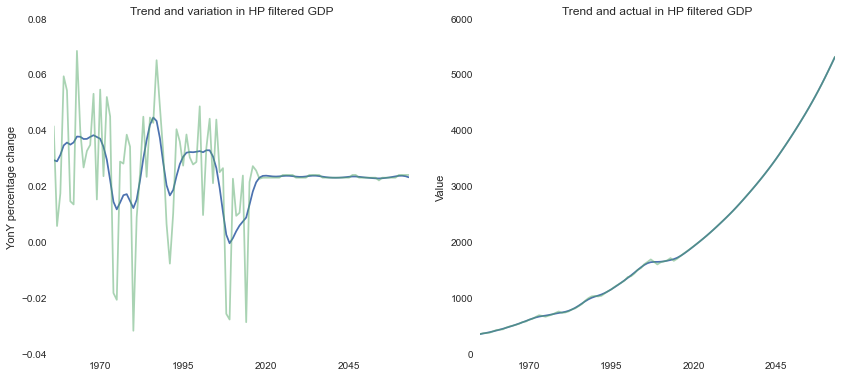

In [17]:
#plot it
start_yr = '1950'

gdp_trend_fig, gdp_trend_ax = plt.subplots(ncols=2, figsize=(14,6))
swiss.gdp_trend.pct_change()[start_yr:].dropna().plot(ax=gdp_trend_ax[0])
swiss.rgdp[start_yr:].pct_change().dropna().plot(ax=gdp_trend_ax[0], alpha=0.5)
gdp_trend_ax[0].set_title('Trend and variation in HP filtered GDP')
gdp_trend_ax[0].set_ylabel('YonY percentage change')

swiss.gdp_trend[start_yr:].dropna().plot(ax=gdp_trend_ax[1])
swiss.rgdp[start_yr:].dropna().plot(ax=gdp_trend_ax[1], alpha=0.5)
gdp_trend_ax[1].set_title('Trend and actual in HP filtered GDP')
gdp_trend_ax[1].set_ylabel('Value')

(23, 93.0)

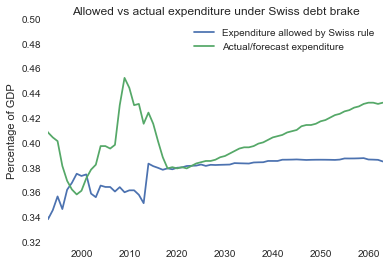

In [18]:
swiss_ax = swiss.allowed_expenditure(pc=True).plot()#figsize=(15, 8))
lr_df['tme'].plot(ax=swiss_ax)
swiss_ax.legend(['Expenditure allowed by Swiss rule', 'Actual/forecast expenditure'], loc='best')
swiss_ax.set_ylabel('Percentage of GDP')
swiss_ax.set_title('Allowed vs actual expenditure under Swiss debt brake')

swiss_ax.set_xlim(left=pd.datetime(1993, 1, 1))

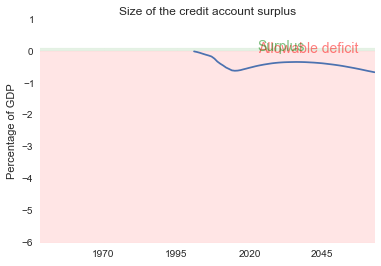

In [19]:
swiss.credit_account(pc=True, from_date=pd.datetime(2000, 6, 1)).plot()
left, right = plt.gca().get_xlim()
bottom, top = plt.gca().get_ylim()
plt.axhspan(-6, 0, xmin=left, xmax=right, alpha=0.1, color='r')
plt.axhspan(0, top, xmin=left, xmax=right, alpha=0.1, color='g')
plt.text(right - 40, -0.04, "Allowable deficit", fontsize=14, color='r', alpha=0.5)
plt.text(right - 40, 0.04, "Surplus", fontsize=14, color='g', alpha=0.5)
plt.title("Size of the credit account surplus")
plt.ylabel('Percentage of GDP')

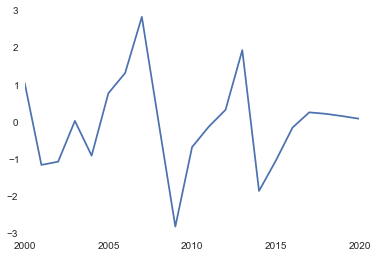

In [20]:
swiss.hp_outputgap['2000':'2020'].plot()

**this appears incorrect but that could be because forecasts are on an ESA95 basis and outturns are on an ESA10 basis so there is a discontinuity at 2013-14. The publication of the new EFO1214 should largely rectify the problem since FSR is specified in growth rates, not in levels.**

#A debt rule for the UK 

Implement a debt rule of the form $\tau_t - g_t = r d_{t-1} + f(d_{t-1} - d^*)$.

where $r$ is the real interest rate minus the growth rate of real gdp. $f$ is the adjustment rate and $d^*$ is the target level of debt. $\tau_t - g_t$ is obviously the primary surplus.

##ZLB policy

The crucial exception is that, when monetary policy is at the ZLB, fiscal policy should not follow the rule. Ideally, the OBR, HMT, and BoE would come up with an appropriate plan. Here I assume that TME continues to grow at 5%pa when the ZLB is struck, its rate of long-term growth.

When the constraint is relaxed fiscal policy can be tightened again but not so quickly as to return monetary policy to the ZLB. Without a macroeconomic model it is difficult to say how fast that is. I assume the gap between the current surplus and debt-rule surplus can be closed by 20 per cent each year.

##Cost of debt

Estimating the cost of debt from this rule is difficult because PSNB depends on the effective rate of interest on PSND. That, in turn, is affected by the dividends and interest rate on debt, which is tricky to predict. The OBR estimates the average net cost of debt to be about 3.25% over the next fifty years so that is used across all periods.

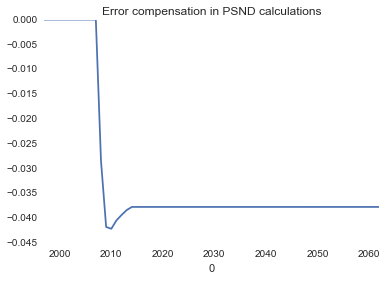

In [21]:
# Calculated error in debt rule evolution. Probably due to bank loans but haven't checked.
# Saved calculated values to CSV rather than generating endogenously to avoid masking 
# future errors with endogenous error removal.
error_df = pd.read_csv("psnd_error_020215.csv", parse_dates=True, index_col=0, header=None).squeeze()
error_df.plot()
plt.title("Error compensation in PSND calculations")

In [63]:
#What discount rate is required for the series to dip under 0.05 within n years?
lookup = {}
for discount in np.linspace(0.03, 0.6, num=100):
    years = 0
    res = 1
    while res >= 0.05:
        res = res * (1 - discount)
        years += 1
    lookup[years] = discount
    
lookup

{4: 0.59999999999999998,
 5: 0.52515151515151515,
 6: 0.45030303030303032,
 7: 0.3927272727272727,
 8: 0.34666666666666668,
 9: 0.31212121212121213,
 10: 0.27757575757575759,
 11: 0.25454545454545452,
 12: 0.23727272727272727,
 13: 0.22,
 14: 0.20272727272727273,
 15: 0.19121212121212119,
 16: 0.17969696969696969,
 17: 0.16818181818181818,
 18: 0.15666666666666665,
 19: 0.15090909090909091,
 20: 0.14515151515151514,
 21: 0.13363636363636364,
 22: 0.12787878787878787,
 24: 0.12212121212121212,
 25: 0.11636363636363636,
 26: 0.1106060606060606,
 28: 0.10484848484848484,
 29: 0.099090909090909091,
 31: 0.093333333333333324,
 33: 0.087575757575757571,
 36: 0.081818181818181818,
 38: 0.076060606060606051,
 42: 0.070303030303030298,
 45: 0.064545454545454545,
 50: 0.058787878787878785,
 55: 0.053030303030303025,
 62: 0.047272727272727272,
 71: 0.041515151515151512,
 83: 0.035757575757575759,
 99: 0.029999999999999999}

In [73]:
class DebtRule():
    """
    A long-term debt rule to bring debt back to a target level at a constant, exponential rate.
    
    Takes:
        ngdp: nominal GDP
        rgdp: real GDP
        debt: Public sector net debt as a percentage of GDP (ie. 38, not 0.38)
        bank_rate: Bank of England's Bank Rate. Required for deviation from rule during ZLB (rate < 0.5%)
        prim_surp: Required if bank_rate is provided to calculate deficit at ZLB
    """
    
    def __init__(self, ngdp, rgdp, debt, tme, receipts, bank_rate, prim_surp):
        self.rgdp = rgdp
        self.ngdp = ngdp
        self.tme_pc = tme
        self.tme = self.tme_pc.mul(self.ngdp)
        self.debt_pc = debt
        self.receipts_pc = receipts
        self.receipts = self.receipts_pc.mul(self.ngdp)
        self.bank_rate = bank_rate
        self.prim_surp = prim_surp
        self.debt = self.debt_pc.mul(self.ngdp)
        self._is_zlb_bool = self._is_zlb()  # Boolean for ZLB
        self._year_lookup = self._gen_lookup_table()
        
    def _gen_lookup_table(self):
        """Generate a dictionary calculating the approach rate from the specified number of years to convergence."""
        lookup = {}
        for discount in np.linspace(0.03, 0.6, num=100):
            years = 0
            res = 1
            while res >= 0.05:  # Within 5% counts as convergence
                res = res * (1 - discount)
                years += 1
            lookup[years] = discount
        return lookup
    
    def _is_zlb(self):
        """Check if bank rate is less than 1% or GDP has fallen in current FY. Return boolean series."""
        return (self.bank_rate <= 1) | (self.rgdp.pct_change() < 0)
    
    def _zlb_surplus(self, date, debt):
        """Calculate the surplus if TME continued to grow at 5%pa."""
        psnb = (self.tme[date - pd.DateOffset(years=1)] * 1.05) - self.receipts[date]
        cost_of_debt = debt * self.gilt_rate[date]
        return -(psnb - cost_of_debt) / self.rgdp[date]
                    
    def _debt_rule(self, date, debt, psurp):
        """
        Takes scalars and returns a scalar for this year's primary surplus.
        """
        rule_val = (self.rir[date] - self.rgdp.pct_change()[date]) * debt + self.feedback * (debt - self.target_debt)
        if any(self._is_zlb_bool[(self._date_range[0]):date]):
            return (1 - self._zlb_smoothing) * rule_val + self._zlb_smoothing * psurp
        return rule_val
    
    def _debt_increment(self, date, debt, psurp):
        """
        Returns a scalar for the additional debt incurred that year.
        """
        rgdp_growth = self.rgdp.pct_change()[date]    
        lambda_t = (1 + self.rir[date]) / (1 + rgdp_growth)
        new_debt = lambda_t * debt - psurp
        return new_debt
    
    def _implied_gilt_rate(self):
        """
        Calculate the effective gilt rate from the input forecast paths.
        """
        return (self.debt_pc.diff() + self.prim_surp).div(self.debt_pc.shift(-1)).mul(1
                                                        + self.ngdp.pct_change()) + self.ngdp.pct_change()
    
    def _gdp_deflator(self):
        """
        Calculate the annual percentage growth in the GDP deflator.
        """
        return self.ngdp.div(self.rgdp).pct_change()
    
    def projections(self, date_range=pd.date_range(pd.datetime(2016, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR'),
                     target_debt=0.2, years_to_converge=50, zlb_smoothing=0.8, austerity=True):
        """
        Generate the paths of the primary surplus and PSND according to the rule.
        
        Takes:
            date_range: date range of projections as pandas.date_range
            target_debt: target level of debt as a proportion of GDP (eg. 0.20)
            feedback: rate of convergence to target debt in proportion eliminated per year (eg. 0.05)
            zlb_smoothing: degree of smoothing as policy transitions from ZLB to debt convergence
            austerity: 
        """
        self.gilt_rate = self._implied_gilt_rate()
        self.rir = self.gilt_rate - self._gdp_deflator()
        self.target_debt = target_debt
        self.feedback = (self._year_lookup[years_to_converge] if years_to_converge in self._year_lookup
                else self._year_lookup[min(self._year_lookup.keys(), key=lambda k: abs(k - years_to_converge))])
        self._zlb_smoothing = zlb_smoothing
        self._date_range = date_range
        
        pdebt = [self.debt_pc[self._date_range[0]]]
        psurp = [float('NaN')]
        for k, v in iter(self.rgdp.pct_change()[self._date_range[1:]].items()):
            if self._is_zlb_bool[k] and not austerity:
                psurp.append(self._zlb_surplus(k, pdebt[-1]))
            elif self._is_zlb_bool[k] and austerity:
                psurp.append(self.prim_surp[k])
            else:
                psurp.append(self._debt_rule(k, pdebt[-1], psurp[-1]))
            pdebt.append(self._debt_increment(k, pdebt[-1], psurp[-1]))
        
        projection = pd.DataFrame(data={'primsurp': psurp, 'psnd': pdebt}, index=self._date_range)
        try:
            projection.psnd[date_range] = projection.psnd[date_range].sub(error_df[date_range])
        except KeyError:
            pass
        return projection

In [74]:
debtrule = DebtRule(lr_df['ngdp'], 
                    lr_df['rgdp'], 
                    lr_df['psnd'],
                    lr_df['tme'],
                    lr_df['pscr'],
                    lr_df['bank_rate'],
                    lr_df['primsurp'])

In [75]:
#Define implicit parameters
proj_range=pd.date_range(pd.datetime(2014, 1, 1), pd.datetime(2064, 1, 1), freq='A-MAR')

#Set up the projections and plots
proj = debtrule.projections(date_range=proj_range, target_debt=0.2, years_to_converge=50, 
                 zlb_smoothing=0.8, austerity=True)

###What are the implications of this debt path for the major public spending areas?

Assume receipts remain as in the OBR projections and calculate the implied change in spending for each of the major areas of expenditure.

In [76]:
def rule_tme():
    prim_surp_diff = proj['primsurp'].sub(debtrule.prim_surp).mul(100)
    allowed_tme = obr_fsr_pc['total managed expenditure'].sub(prim_surp_diff)
    return allowed_tme.dropna()

In [77]:
# Create traces
x = rule_tme().index.format()
trace1 = Scatter(x=x,
              y=rule_tme().values,
              name='Expenditure allowed by rule')
trace2 = Scatter(x=x,
                  y=obr_fsr_pc_hp['total managed expenditure'].values,
                  name='Projected expenditure (current health productivity)')
trace3 = Scatter(x=x,
              y=obr_fsr_pc['total managed expenditure'].values,
              name='Projected TME (high health productivity)')
trace4 = Scatter(x=x,
                  y=obr_fsr_pc_hp['public sector current receipts'].values,
                  name='Projected tax revenues')

# Aggregate traces to Data
data2 = Data([trace1, trace2, trace3, trace4])

# Create Layout
layout2 = Layout(title='Size of the state implied by the debt rule',
                 legend=Legend(),
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig2 = Figure(data=data2, layout=layout2)

url = py.plot(fig2, filename='size_of_state', auto_open=False)
tls.embed(url)

In [78]:
def interest_payments(df):
    #rule_net_interest = df['gilt rate'].div(100.).mul(proj['psnd']).mul(100.)
    implied_gilt_rate = df['net interest'].div(df['public sector net debt'])
    rule_net_interest = implied_gilt_rate.mul(proj['psnd']).mul(100.)
    fsr_net_interest = df['net interest']
    interest_diff = rule_net_interest.sub(fsr_net_interest).mul(-1.)
    return interest_diff
    

# Aggregate traces to Data
data = Data([Bar(x=interest_payments(obr_fsr_pc_hp).dropna().index.format(),
                 y=interest_payments(obr_fsr_pc_hp).dropna().values,
                name='Relative to current health productivity scenario'),
            Bar(x=interest_payments(obr_fsr_pc).dropna().index.format(),
                 y=interest_payments(obr_fsr_pc).dropna().values,
                name='Relative to high health productivity scenario')])

# Create Layout
layout = Layout(title='Annual saving in debt interest repayments',
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig = Figure(data=data, layout=layout)

url = py.plot(fig, filename='debt_interest', auto_open=False)
tls.embed(url)

In [79]:
np.npv(0.05, interest_payments(obr_fsr_pc_hp).dropna().values)

13.53762208519993

In [80]:
obr_fsr_pc_hp.iloc[-1, :].div(obr_fsr_pc_hp.iloc[0, :]).order(ascending=False)

net interest                      4.777778
public sector net borrowing       2.793103
public sector net debt            2.733333
gilt rate                         1.923077
long-term care                    1.916667
primary balance                   1.900000
health                            1.822785
capital taxes                     1.538462
pensions                          1.362069
total managed expenditure         1.259770
total non-interest spending       1.111111
income tax                        1.105263
real gdp growth                   1.086957
total non-interest revenue        1.024658
public sector current receipts    1.023873
nics                              1.000000
nominal gdp growth                1.000000
vat                               0.969231
other taxes                       0.961538
other social benefits             0.913793
pensioner benefits                0.900000
corporation tax                   0.875000
education                         0.792453
other spend

In [81]:
# Create traces
x = obr_fsr_pc_hp['2015-3-1':].index.format()
trace1 = Scatter(x=x,
              y=obr_fsr_pc_hp[['education']].sum(axis=1)['2015-3-1':].values,
              name='Education',
                fill='tozeroy')
trace2 = Scatter(x=x,
                  y=obr_fsr_pc_hp[['education', 'pensions', 'pensioner benefits']].sum(axis=1)['2015-3-1':].values,
                  name='Pensions and pensioner benefits',
                fill='tonexty')
trace3 = Scatter(x=x,
              y=obr_fsr_pc_hp[['health', 'long-term care', 'pensions', 'pensioner benefits', 'education']].sum(axis=1)['2015-3-1':].values,
              name='Health and long-term care',
                fill='tonexty')
trace4 = Scatter(x=rule_tme().index.format(),
                  y=rule_tme().values,
                  name='Other spending within debt rule',
                fill='tonexty')

# Aggregate traces to Data
data2 = Data([trace1, trace2, trace3, trace4])

# Create Layout
layout2 = Layout(title='Implications of spending protections for the public finances',
                 legend=Legend(),
                 yaxis=YAxis(title='Percentage of GDP'))

# Create Figure
fig2 = Figure(data=data2, layout=layout2)

url = py.plot(fig2, filename='tme_breakdown', auto_open=False)
tls.embed(url)

In [82]:
mytmpser = rule_tme().sub(obr_fsr_pc_hp[['health', 'long-term care', 'pensions', 'pensioner benefits', 'education']].sum(axis=1))
print("The cut in 'other expenditure' from peak to 2063 will be", 1 - mytmpser.min() / mytmpser.max(), "per cent")

The cut in 'other expenditure' from peak to 2063 will be 0.457309473823 per cent


##Plotly interactive

In [83]:
def plotly_results(year_from=2007, year_to=2063, target_debt=0.2, years_to_converge=50, 
                 zlb_smoothing=0.8, austerity=True):
    """
    Generate plots of primary surplus and debt, given parameters. Used in interaction below.
    """
    
    #Define implicit parameters
    proj_range=pd.date_range(pd.datetime(year_from, 1, 1), pd.datetime(year_to, 1, 1), freq='A-MAR')
    
    #Set up the projections and plots
    proj = debtrule.projections(date_range=proj_range, target_debt=target_debt, years_to_converge=years_to_converge, 
                               zlb_smoothing=zlb_smoothing, austerity=austerity)
    
    #Plot it
    init_date = proj_range[0]
    # Create traces
    x = proj.index.format()
    trace1 = Bar(x=x,
                  y=proj['primsurp'].values,
                  name='Rule-based primary surplus')
    trace2 = Scatter(x=x,
                      y=proj['psnd'].values * 100,
                      name='Rule-based government debt',
                      mode='lines',
                      yaxis='y2',
                      line=Line(shape='spline'))
    trace3 = Bar(x=x,
                  y=lr_df['primsurp'][init_date:].values,
                  name='Actual/forecast surplus (high health productivity)',
                  opacity=0.3)
    trace4 = Scatter(x=x,
                      y=lr_df['psnd'][init_date:].values * 100,
                      name='Actual/forecast debt (high health productivity)',
                      mode='lines',
                      yaxis='y2',
                      opacity=0.3,
                      line=Line(shape='spline'))
    trace5 = Bar(x=obr_fsr_pc_hp['primary balance'][init_date:].index.format(),
                  y=obr_fsr_pc_hp['primary balance'][init_date:].div(100).values,
                  name='Actual/forecast surplus (current health productivity)',
                  opacity=0.3)
    trace6 = Scatter(x=obr_fsr_pc_hp['public sector net debt'][init_date:].index.format(),
                      y=obr_fsr_pc_hp['public sector net debt'][init_date:].values,
                      name='Actual/forecast debt (current health productivity)',
                      mode='lines',
                      yaxis='y2',
                      opacity=0.3,
                      line=Line(shape='spline'))

    # Aggregate traces to Data
    data1 = Data([trace1, trace3, trace2, trace4, trace5, trace6])
    
    # Create Layout
    layout1 = Layout(title='Rule-based public Finances',
                     legend=Legend(traceorder='reversed'),
                     yaxis=YAxis(domain=[0, 0.45], title='Percentage of GDP'),
                     yaxis2=YAxis(domain=[0.55, 1], title='Percentage of GDP'))
    
    # Create Figure
    return Figure(data=data1, layout=layout1)

fig1 = plotly_results()
url = py.plot(fig1, filename='debt_rule', auto_open=False)
tls.embed(url)

In [102]:
g = GraphWidget(url)

#year_from_w = widgets.Dropdown(values=[x for x in range(1993, 2015)], value=2007, description='Initial year')
#year_to_w = widgets.Dropdown(values=[x for x in range(1997, 2064)], value=2063, description='Final year')
target_debt_w = widgets.FloatSlider(min=10, max=80, step=2, value=40, description='Target debt')
feedback_w = widgets.FloatSlider(min=5, max=100, step=2, value=50, description='Years to convergence')
#zlb_smoothing_w = widgets.FloatSlider(min=0, max=0.95, step=0.05, value=0.8, description='Degree of ZLB-exit smoothing')
#austerity_w = widgets.Checkbox(value=True, description='Implement Coalition austerity?')

# my_widgets = [year_from_w, year_to_w, target_debt_w, feedback_w, zlb_smoothing_w, austerity_w]
my_widgets = [target_debt_w, feedback_w]

def regraph():
#     proj_range = pd.date_range(pd.datetime(year_from_w.value, 1, 1), pd.datetime(year_to_w.value, 1, 1), freq='A-MAR')
    proj_range = pd.date_range(pd.datetime(2007, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR')
    new_data = debtrule.projections(date_range=proj_range, target_debt=target_debt_w.value/100, years_to_converge=feedback_w.value)#, 
#                                zlb_smoothing=zlb_smoothing_w.value, austerity=austerity_w.value)
    new_data.fillna(0, inplace=True)
    x = new_data.index.format()
    g.restyle({'x': [x, x], 'y': [new_data['primsurp'].values, new_data['psnd'].values]}, indices=[0, 2])
    
    
for w in my_widgets:
    w.on_trait_change(regraph, 'value')
    display(w)

display(g)

##Generate all values and write to json

In [135]:
def build_chart_data(target_debt, years_allowed):
    proj_range = pd.date_range(pd.datetime(2007, 1, 1), pd.datetime(2063, 1, 1), freq='A-MAR')
    projections = debtrule.projections(date_range=proj_range, target_debt=target_debt / 100, 
                             years_to_converge=years_allowed)
    projections.columns = ['primsurp_rule', 'psnd_rule']
    init_date = proj_range[0]
    
    static_df = pd.concat([lr_df['primsurp'][init_date:],
                    lr_df['psnd'][init_date:],
                    obr_fsr_pc_hp['primary balance'][init_date:].div(100),
                    obr_fsr_pc_hp['public sector net debt'][init_date:].div(100)], join='outer', axis=1)
    static_df.columns = ['primsurp_static_highprod',
                        'psnd_static_highprod',
                        'primsurp_static_currprod',
                        'psnd_static_currprod']
    return proj.join(static_df)


results = {}
results["variable1"] = "Target debt level"
results["values"] = {}
for target_debt in range(10, 80, 5):
    results["values"][target_debt] = {}
    results["values"][target_debt]["variable2"] = "Years to target"
    results["values"][target_debt]["values"] = {}
    for years_allowed in range(5, 100, 5):
        new_data = build_chart_data(target_debt, years_allowed)
        results["values"][target_debt]["values"][years_allowed] = json.loads(new_data.to_json(orient='split'))
        results["values"][target_debt]["values"][years_allowed]['long_names'] = ['Rule-based primary surplus',
                                                                                'Rule-based net debt',
                                                                                'Actual/forecast surplus (high health productivity)',
                                                                                'Actual/forecast debt (high health productivity)',
                                                                                'Actual/forecast surplus (current health productivity)',
                                                                                'Actual/forecast debt (current health productivity)']

In [136]:
import json

with open("results.json","w") as f:
    json.dump(results, f)